In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from energy_consumption.models.lasso import functions

### 1. Include all desired features 
* make sure they are still reasonable
* Assume Lasso can handle this 

In [2]:
24*365*5

43800

In [33]:
# important to standardize X for lasso regression
# use derived opt for quantReg
energydata = extract_all_features.get_energy_and_standardized_features2(
    lasso_check=True)

y = energydata[['energy_consumption']]
X = energydata.drop(columns=['energy_consumption'])
X.insert(loc=0, column='constant', value=1)

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


In [3]:
energydata.columns

Index(['abs_log_ret_weekly', 'sun_hours', 'tavg', 'wspd', 'index',
       'population', 'energy_consumption', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'year_2022', 'year_2023', 'year_2024', 'holiday'],
      dtype='object')

In [ ]:
X

In [4]:
correlation_matrix = X.corr()

# Find pairs of variables with absolute correlation value greater than 0.1
high_corr_pairs = [(i, j) for i in range(correlation_matrix.shape[0])
                   for j in range(i+1, correlation_matrix.shape[1])
                   if abs(correlation_matrix.iloc[i, j]) > 0.7]

# Create a copy of the original predictor matrix
X_pol = X.copy()

# Add interaction terms for selected pairs
for pair in high_corr_pairs:
    col1, col2 = X.columns[pair[0]], X.columns[pair[1]]
    name = f"{col1}_{col2}"
    X_pol[name] = X_pol[col1] * \
        X_pol[col2]

# add polynomials 
X_pol['tavg_2'] = X_pol['tavg']**2

In [5]:
X_pol

,constant,abs_log_ret_weekly,sun_hours,tavg,wspd,index,population,hour_1,hour_2,hour_3,...,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,holiday,sun_hours_tavg,tavg_2
date_time,,,,,,,,,,,,,,,,,,,,,
2016-12-28 00:00:00,1,-1.279206,-1.494589,-0.809877,0.452635,-0.780564,-1.729508,0,0,0,...,0,0,0,0,0,0,0,0,1.210434,0.655901
2016-12-28 01:00:00,1,-1.279206,-1.494589,-0.809877,0.452635,-0.780564,-1.729508,1,0,0,...,0,0,0,0,0,0,0,0,1.210434,0.655901
2016-12-28 02:00:00,1,-1.279206,-1.494589,-0.809877,0.452635,-0.780564,-1.729508,0,1,0,...,0,0,0,0,0,0,0,0,1.210434,0.655901
2016-12-28 03:00:00,1,-1.279206,-1.494589,-0.809877,0.452635,-0.780564,-1.729508,0,0,1,...,0,0,0,0,0,0,0,0,1.210434,0.655901
2016-12-28 04:00:00,1,-1.279206,-1.494589,-0.809877,0.452635,-0.780564,-1.729508,0,0,0,...,0,0,0,0,0,0,0,0,1.210434,0.655901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 08:00:00,1,-0.875593,-1.268130,-1.520221,-0.579297,-1.969241,1.766801,0,0,0,...,0,0,0,0,0,1,0,0,1.927838,2.311071
2023-11-22 09:00:00,1,-0.875593,-1.268130,-1.520221,-0.579297,-1.969241,1.766801,0,0,0,...,0,0,0,0,0,1,0,0,1.927838,2.311071
2023-11-22 10:00:00,1,-0.875593,-1.268130,-1.520221,-0.579297,-1.969241,1.766801,0,0,0,...,0,0,0,0,0,1,0,0,1.927838,2.311071


In [ ]:
y

In [8]:
# Time-based split for time series data
tscv = TimeSeriesSplit(n_splits=50, test_size=100)  # Adjust the number of splits as needed

# Create LassoCV model with time series cross-validation
# let alphas = None to automatically compute best alpha
lasso_cv = LassoCV(cv=tscv,max_iter=1000)

# Fit the model on the scaled data
lasso_cv.fit(X_pol, y)

# Find the best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha: 0.006397945485390886


In [9]:
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_pol, y)
print(list(zip(lasso_best.coef_, X_pol)))

[(0.0, 'constant'), (-0.13319353295000816, 'abs_log_ret_weekly'), (-1.7934103055236275, 'sun_hours'), (-1.1432515573427406, 'tavg'), (0.8929566414182688, 'wspd'), (1.5906023972863688, 'index'), (-0.15226896754071295, 'population'), (-3.6096166082505605, 'hour_1'), (-4.525316026938646, 'hour_2'), (-4.4377371568465005, 'hour_3'), (-3.5250299838365637, 'hour_4'), (-1.201339540183923, 'hour_5'), (3.602894336401277, 'hour_6'), (8.049799141600513, 'hour_7'), (11.026604514096947, 'hour_8'), (12.508720708396554, 'hour_9'), (13.762031402247626, 'hour_10'), (14.840901630000523, 'hour_11'), (14.405101027351828, 'hour_12'), (13.200208664736602, 'hour_13'), (11.858896173910814, 'hour_14'), (11.051607132207025, 'hour_15'), (10.640701262468227, 'hour_16'), (11.655592454201695, 'hour_17'), (12.220079616753624, 'hour_18'), (11.626077631690043, 'hour_19'), (9.217179059146064, 'hour_20'), (6.67549352274654, 'hour_21'), (4.2418711223044445, 'hour_22'), (0.6871171163605956, 'hour_23'), (1.118507499992135, 

How to estimate forecast variance? 
--> estimate residuals for each forecast horizon (p=100). 
If we estimate more than 40, we can assume they are normal distributed. 

In [11]:
len(X_pol)

60541

In [10]:
# before: timeteriessplit with n_splits = 400, erst ab der Hälfte residuen berechnet (damit genug trainingsdaten)

# Perform time series split
tscv = TimeSeriesSplit(n_splits=300, test_size=100)
indexes = list(range(100))
residuals = pd.DataFrame()
for i in indexes:
    residuals[f'{i}'] = np.nan

for train_index, test_index in tscv.split(X_pol):

    # fit Lasso Regression with best alpha
    lasso = Lasso(alpha=0.0064)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the scaled data
    lasso.fit(X_train, y_train)

    # estimate forecast means
    mean_est = lasso.predict(X_test)[indexes]

    # residuals based on horizon
    y_obs = np.array(y_test).flatten()
    residuals_est = y_obs - mean_est

    # safe
    residuals.loc[len(residuals)] = residuals_est

In [11]:
mean_values = residuals.mean(axis=0)
std_dev_values = residuals.std(axis=0)
std_dev_values
residuals3= residuals

In [12]:
# export residuals to avoid additional computational effort
residuals3.to_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals3.csv', index=False)

# check if residuals vary over time 
--> iterate over rows, check if there is trend in mean/variance of residuals
--> works

In [7]:
residuals3 = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals3.csv')
residuals3

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.065073,-1.378810,-1.479054,-1.166906,-1.720062,-1.507037,-1.422443,-0.989931,-0.224136,1.342544,...,1.314582,1.919979,1.630223,1.618452,1.468278,1.652459,1.925641,1.699154,1.573910,0.866308
1,-0.532849,-1.355610,-1.813305,-1.493592,-1.484370,-1.229172,-1.146531,-2.587080,-0.547371,-0.743239,...,-0.700711,-0.002589,-0.306004,0.005393,-0.172304,-0.247916,-0.544419,-0.546181,-0.355125,1.048838
2,2.525067,4.716626,5.750177,-8.210661,-5.593263,-5.150119,-5.087712,-4.904110,-4.082774,-1.297152,...,2.812279,1.395691,0.157560,-1.488808,-2.029486,-1.843303,-1.550875,-1.491316,-1.621264,-3.370325
3,-1.802868,-1.903317,-2.236141,-2.599202,-3.063678,-2.848388,-2.262220,-1.483098,-0.858111,-0.531086,...,0.153759,0.499752,0.271484,0.333303,0.478320,-1.867890,0.035180,-0.540269,-1.212343,-1.723654
4,-2.063248,-1.446503,-1.261432,0.123115,0.881439,1.070185,1.049961,2.272339,3.349183,2.880280,...,-1.634230,5.027868,6.771380,5.879009,5.005060,3.818316,1.401935,-2.199819,-4.682249,-4.326952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-4.014886,-3.894684,-4.125525,-3.971674,-3.885635,-3.368367,-2.932064,-6.030088,-4.447259,-4.188582,...,-2.372145,-1.646443,-2.329724,-2.309266,-1.551708,-0.175699,2.299911,2.783613,2.506522,2.941623
296,4.349382,6.068435,8.000620,-4.350690,-1.840011,-1.794183,-1.324395,-1.131734,0.413162,4.610296,...,2.566236,3.254189,4.347738,3.092832,2.678681,2.127249,1.003703,-0.082993,-0.655059,-1.046879
297,-0.013441,0.240348,0.258471,0.486975,1.839438,4.660217,5.835557,4.874972,3.540118,3.297516,...,5.329175,4.169315,3.835645,2.845827,2.923994,-1.430822,0.559355,1.036645,1.335018,1.588272
298,3.765825,7.325235,6.953736,6.923157,6.380869,6.482480,5.902562,5.629147,5.239683,4.444536,...,-1.748879,4.718473,6.288158,5.934556,5.228085,4.393398,2.397802,-1.015788,-2.788287,-2.227367


Check if residual swings around zero in each of the forecasting horizons (recursively change indexes)

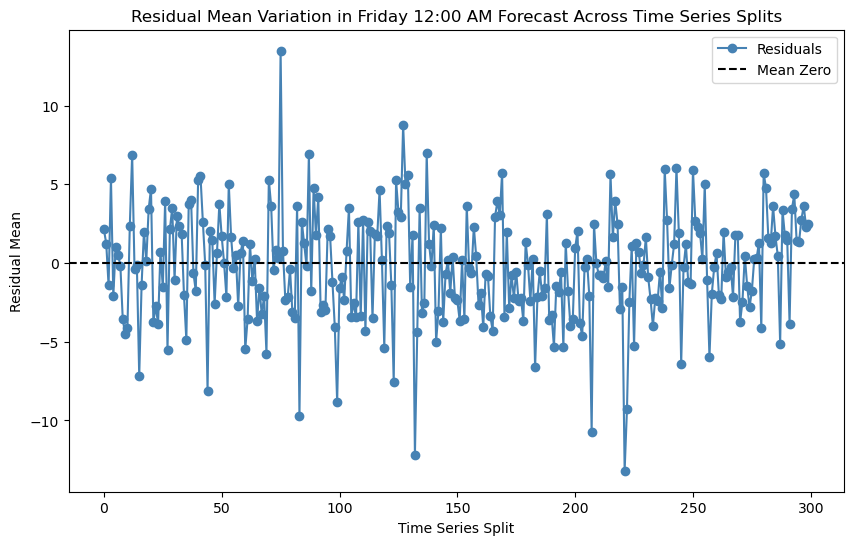

In [20]:
import matplotlib.pyplot as plt

# Calculate the mean of each row
residual_ind = residuals3[['47']]

# Plot the mean values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residual_ind, marker='o', linestyle='-',
         color='steelblue', label='Residuals')
# Add a horizontal line for the mean
plt.axhline(y=0, color='black', linestyle='--', label='Mean Zero')
plt.title(
    'Residual Mean Variation in Friday 12:00 AM Forecast Across Time Series Splits')
plt.xlabel('Time Series Split')
plt.ylabel('Residual Mean')
plt.legend()
plt.show()

# further variances to consider: temp, wspd and prodInd

estimated beta-coefficients: 
tavg: -1.1428
tavg_2: 0.6207
tavg_sun_hours: 0.4323
Wspd: 0.9242
wspd_2: 0.0204
index: 1.6932

add to variance: 
beta_hat^2 * var^2

In [2]:
# Note: the more comparisons we have, the better. However, we started very lately with including weather data. Therefore, this  is just a proxy.
from sklearn.preprocessing import StandardScaler

# proxy for tavg and wspd: 
weather_obs = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_01172024.csv')
weather_est = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_010824.csv')
weather_obs2 = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_012424.csv'
)

# Extract numeric columns for standardization (comparably the same length as training data for lasso regression)
cols = ['wspd', 'tavg']

# Standardize the columns
scaler = StandardScaler()

weather_est[cols] = scaler.fit_transform(
    weather_est[cols])
weather_obs[cols] = scaler.transform(
    weather_obs[cols])
weather_obs2[cols] = scaler.transform(
    weather_obs2[cols])

# Rename and select relevant columns
weather_est_date = weather_est[['date', 'wspd', 'tavg']].rename(
    columns={'wspd': 'wspd_est', 'tavg': 'tavg_est'})
weather_obs_date = weather_obs[-16:][['date', 'wspd', 'tavg']
                                     ].rename(columns={'wspd': 'wspd_obs', 'tavg': 'tavg_obs'})

# Rename and select relevant columns
weather_obs2_date = weather_obs2[['date', 'wspd', 'tavg']].rename(
    columns={'wspd': 'wspd_est', 'tavg': 'tavg_est'})
weather_est2_date = weather_obs[-8:][['date', 'wspd', 'tavg']
                                     ].rename(columns={'wspd': 'wspd_obs', 'tavg': 'tavg_obs'})

# Merge DataFrames based on the 'date' column
merged_df = pd.merge(weather_est_date, weather_obs_date,
                     on='date', how='inner')
merged_df['tavg_residual'] = merged_df['tavg_obs'] - merged_df['tavg_est']
merged_df['wspd_residual'] = merged_df['wspd_obs'] - merged_df['wspd_est']

# Merge DataFrames based on the 'date' column
merged_df2 = pd.merge(weather_est2_date, weather_obs2_date,
                     on='date', how='inner')
merged_df2['tavg_residual'] = merged_df2['tavg_obs'] - merged_df2['tavg_est']
merged_df2['wspd_residual'] = merged_df2['wspd_obs'] - merged_df2['wspd_est']

merged_df = pd.concat([merged_df, merged_df2])


var_to_add_wsp = merged_df['wspd_residual'].var() # (0.9424)
var_to_add_temp = merged_df['tavg_residual'].var()  # (0.0833)
var_to_add_wsp

# residuals do not really make sense since they are higher for later periods --> just add the same portion to each horizon

NameError: name 'pd' is not defined

In [ ]:
merged_df

Variance proxy for production index
--> Production index estimated with OLS --> estimate variance of OLS estimation

In [7]:
from energy_consumption.feature_selection.collect import production_index
from energy_consumption.feature_selection.extract import extract_all_features

# get unscaled energydata since OLS residuals are unscaled as well
energydata_unsc = extract_all_features.get_energy_and_features(
    lasso=True)[-54027:]
index_data_unsc = energydata_unsc['index']

var_est = index_data_unsc.var()
mean_est = index_data_unsc.mean()

residuals = production_index.merge_production_indexes(energydata_unsc)[2]

mean_res = residuals.mean()
var_est = residuals.var()

# standardize residuals
res_standardized = (residuals-mean_res)/(var_est)
var_to_add = res_standardized.var()
var_to_add # (0.0379)

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


0.037922818482804745

Betas: 
tavg: -1.1432515573427406
tavg_2: 0.6355930457555262
tavg_sun_hours: 0.3665032643986151
Wspd: 0.8929566414182688
index: 1.5906023972863688


In [9]:
# abstract from specific forecasting horizons for simplicity --> just add overall variance 
# for polynomial, also take the sqaure of the variance of daily temperature

overall_variance_to_add = var_to_add * (1.6045083021151594)**2 + \
    var_to_add_temp*(1.1432515573427406+0.3665032643986151)**2 + (var_to_add_temp)**2 *(0.6355930457555262)**2 + \
    var_to_add_wsp*0.8929566414182688**2 


overall_variance_to_add #(1.0417)

1.0416620395660043

Use alpha = 0.0064 for Lasso Regression

In [4]:
def get_interaction_and_pol_terms(X): 

    # interaction term for sun_hours and tavg
    X['sun_hours_tavg'] = X['sun_hours'] * X['tavg']
            
    # Add polynomials
    X['tavg_2'] = X['tavg']**2
    return X

In [3]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from math import sqrt

def get_quantiles(mean_est, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975]):

    mean_est = np.array(mean_est)
    quantile_df = pd.DataFrame()

    # lasso variance
    residuals = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
    residual_std = np.sqrt(residuals.var(axis=0))

    # add variance due to forecasts of regressors
    std_to_add = sqrt(1.0417)

    for q in quantiles:
        quantile_df[f'q{q}'] = mean_est + \
                residual_std*norm.ppf(q, loc=0) + \
                (std_to_add+0.5)*norm.ppf(q, loc=0)

    return quantile_df

In [5]:
energydata = extract_all_features.get_energy_and_standardized_features2(
    lasso_check=True)[-54027:]

y = energydata[['energy_consumption']]
X = energydata.drop(columns=['energy_consumption'])
X.insert(loc=0, column='constant', value=1)
X = X.drop(columns=['year_2016', 'year_2024'])
X

NameError: name 'extract_all_features' is not defined

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from energy_consumption.feature_selection.collect import dummy_mapping, political_instability, weather_sunhours, weather_tempandwind, population, production_index, prices
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
def get_energy_and_standardized_features2(energydf=np.nan, lasso=False, lasso_check=False, knn=False):

    if type(energydf) == float:
        energydata = pd.read_csv(
            'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
        energydata['date_time'] = pd.to_datetime(
            energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
        energydata = energydata.set_index("date_time")
        energydata = impute_outliers(energydata)
    else: 
        energydata = energydf.copy()
    

    if lasso_check == True:  # try to change
        print('did you update weather and index?')
        energydata = (energydata
                      .pipe(political_instability.ec_dax_merge)
                      .pipe(weather_sunhours.ec_sun_hours_merge)
                      .pipe(weather_tempandwind.ec_weather_merge)
                      .pipe(production_index.merge_production_indexes)[0]
                      .pipe(population.get_population)
                      )
        energydata = energydata.drop(
            columns=['close_weekly', 'volatility_weekly'])
        if 'abs_log_ret_weekly' in energydata.columns and energydata['abs_log_ret_weekly'].isna().any():
            energydata['abs_log_ret_weekly'] = energydata['abs_log_ret_weekly'].fillna(0)
        
    # check if energydata only contains predictors or target as well
    if 'energy_consumption' in energydata.columns:
        X = energydata.drop(columns=['energy_consumption'])
        y = energydata.reset_index()[['energy_consumption', 'date_time']]
    else:
        X = energydata

    # Fit the scaler on your data and transform the features
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)

    if 'energy_consumption' in energydata.columns:
        X_standardized_df['energy_consumption'] = y['energy_consumption']
        X_standardized_df['date_time'] = y['date_time']
    else:
        X_standardized_df['date_time'] = energydata.index

    X_standardized_df = X_standardized_df.set_index('date_time')

    X_standardized_df = dummy_mapping.get_mappings(X_standardized_df)

    return X_standardized_df

In [10]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso

from energy_consumption.help_functions.drop_years import drop_years
from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from evaluation.help_functions.prepare_data import most_recent_wednesday
#from energy_consumption.help_functions,drop_years import drop_years

def get_Lasso_forecasts(energydata=pd.DataFrame(), indexes=[47, 51, 55, 71, 75, 79],
                        quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100, abs_eval = False, wednesday_morning=False):

    if energydata.empty:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data()     #0.25
    
    # get standardized features
    energydata = get_energy_and_standardized_features2(energydata,       #extract_all
        lasso_check=True)
    
    #if abs_eval == True: 
        # ensure last wednesday
    #    start_date = most_recent_wednesday(energydata)
    #    energydata = energydata.loc[energydata.index <= start_date].copy()
    #    energydata = extract_energy_data.set_last_wed(energydata, wednesday_morning)
     
    # split df
    y = energydata[['energy_consumption']]
    X = energydata.drop(columns=['energy_consumption'])
    X.insert(loc=0, column='constant', value=1)
    X = get_interaction_and_pol_terms(X)
    
    # create dataframe to store forecast quantiles
    X_fc = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])
    
    X_fc = get_energy_and_standardized_features2(                      
        X_fc, lasso_check=True)
    X_fc = get_interaction_and_pol_terms(X_fc)
    X_fc.insert(loc=0, column='constant', value=1)
    print(X_fc)
    # drop years
    X, X_fc = drop_years(X, X_fc)
    
    # fit Lasso Regression with best alpha
    lasso = Lasso(alpha=0.0064)

    # Fit the model on the scaled data
    lasso.fit(X, y)

    # estimate forecast means
    mean_est = lasso.predict(X_fc).flatten()
    print(mean_est)

    # estimate quantile forecasts
    quantile_forecasts = get_quantiles(
        mean_est, quantiles).iloc[indexes]
    
    # return quantile forecasts in terms of absolute evaluation
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_forecasts.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_forecasts

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_forecasts, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame

In [8]:
energydata = extract_energy_data.get_data(6.17)
energydata

100%|██████████| 320/320 [03:47<00:00,  1.41it/s]


,energy_consumption
date_time,
2017-12-11 00:00:00,52.39825
2017-12-11 01:00:00,50.44125
2017-12-11 02:00:00,49.91650
2017-12-11 03:00:00,50.05400
2017-12-11 04:00:00,51.41475
...,...
2024-01-24 08:00:00,71.52975
2024-01-24 09:00:00,71.68775
2024-01-24 10:00:00,72.02475


In [ ]:
forecasts = get_Lasso_forecasts(energydata[:-504], indexes = list(range(20)), quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], abs_eval = True)
X

### Absolute model evaluation

In [ ]:
lasso_forecasts = get_Lasso_forecasts(energydata[:-335], indexes=list(range(
    50)), abs_eval=True)
lasso_forecasts

False

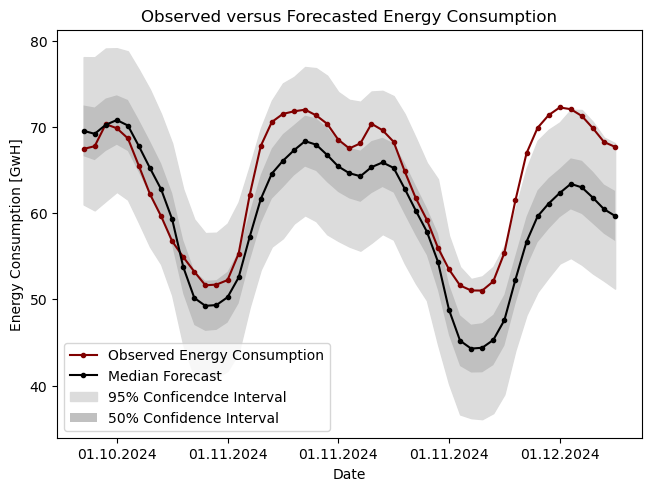

In [56]:
import matplotlib.pyplot as plt

lasso_forecasts = get_Lasso_forecasts(energydata[:-168], indexes=list(range(
    50)), abs_eval=True)

obs = energydata.iloc[-168:-68]

dates = obs.index
dates = np.array(dates.strftime("%m.%d.%Y"))
x = np.array(range(len(dates)-1))

# determine 5 xticks
quotient = round(len(dates)/5)
ticks = [int(i * quotient - quotient * 0.7) for i in range(1, 6)]

# make figure + axes
fig, ax = plt.subplots(layout='constrained')
ax.set(title="Observed versus Forecasted Energy Consumption",
       xlabel="Date",
       ylabel="Energy Consumption [GwH]")

# plot observed ec and median ec
ax.plot(x, obs[1:], marker=".", color='maroon',
        label='Observed Energy Consumption')
ax.plot(x, lasso_forecasts['q0.5'][1:], marker='.',
        color='black', label='Median Forecast')

# fill in confidence intervals
ax.fill_between(x, lasso_forecasts['q0.025'][1:],
                lasso_forecasts['q0.975'][1:],
                color='gainsboro', label='95% Conficendce Interval')
ax.fill_between(x, lasso_forecasts['q0.25'][1:],
                lasso_forecasts['q0.75'][1:],
                color='silver', edgecolor=None, label='50% Confidence Interval')

# set x-axis ticks directly using dates
ax.set_xticks(ticks, labels=[dates[i] for i in ticks])
ax.legend()
len(dates) == len(x)

In [13]:
lasso_forecasts1 = get_Lasso_forecasts(
    energydata[:-168], indexes=list(range(100)), abs_eval=True)
lasso_forecasts2 = get_Lasso_forecasts(
    energydata[:-335], indexes=list(range(100)), abs_eval=True)
lasso_forecasts3 = get_Lasso_forecasts(
    energydata[:-504], indexes=list(range(100)), abs_eval=True)
lasso_forecasts4 = get_Lasso_forecasts(
    energydata[:-672], indexes=list(range(100)), abs_eval=True)
lasso_forecasts5 = get_Lasso_forecasts(
    energydata[:-840], indexes=list(range(100)), abs_eval=True)

did you update weather and index?
2017-12-11 00:00:00
2024-01-18 12:00:00
did you update weather and index?
2024-01-17 13:00:00
2024-01-22 16:00:00
                     constant  abs_log_ret_weekly  sun_hours      tavg  \
date_time                                                                
2024-01-17 13:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 14:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 15:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 16:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 17:00:00         1        3.330669e-16  -1.655125  0.020779   
...                       ...                 ...        ...       ...   
2024-01-21 12:00:00         1        3.330669e-16   1.512349  1.779041   
2024-01-21 13:00:00         1        3.330669e-16   1.512349  1.779041   
2024-01-21 14:00:00         1        3.330669e-16   1.512349  1.779041   
2024-01-21 15:00:00         1        3

In [14]:
lasso_forecasts_all = pd.concat([lasso_forecasts2, lasso_forecasts3])
lasso_forecasts_all = lasso_forecasts_all.sort_values(by='date_time')
lasso_forecasts_all

,date_time,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-03 13:00:00,57.710701,63.793608,66.985316,70.177024,76.259931
1,2024-01-03 14:00:00,56.136281,62.382713,65.660223,68.937733,75.184166
2,2024-01-03 15:00:00,55.018463,61.483702,64.876020,68.268338,74.733577
3,2024-01-03 16:00:00,54.699007,61.144852,64.526994,67.909136,74.354981
4,2024-01-03 17:00:00,56.261628,62.368177,65.572289,68.776402,74.882951
...,...,...,...,...,...,...
95,2024-01-14 13:00:00,40.528431,46.877402,50.208714,53.540026,59.888996
96,2024-01-14 14:00:00,39.739632,45.737060,48.883918,52.030775,58.028204
97,2024-01-14 15:00:00,38.830130,44.910113,48.100286,51.290459,57.370442
98,2024-01-14 16:00:00,38.177634,44.458586,47.754208,51.049831,57.330783


In [20]:
df_observations = energydata[-530:-220].reset_index()
df_combined = df_observations.merge(lasso_forecasts_all, how='left', on='date_time')
df_combined

,date_time,energy_consumption,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-02 11:00:00,59.91550,NaN,NaN,NaN,NaN,NaN
1,2024-01-02 12:00:00,59.88825,NaN,NaN,NaN,NaN,NaN
2,2024-01-02 13:00:00,59.29250,NaN,NaN,NaN,NaN,NaN
3,2024-01-02 14:00:00,58.04625,NaN,NaN,NaN,NaN,NaN
4,2024-01-02 15:00:00,58.47375,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
305,2024-01-15 04:00:00,49.82400,NaN,NaN,NaN,NaN,NaN
306,2024-01-15 05:00:00,53.41200,NaN,NaN,NaN,NaN,NaN
307,2024-01-15 06:00:00,61.55575,NaN,NaN,NaN,NaN,NaN
308,2024-01-15 07:00:00,68.27625,NaN,NaN,NaN,NaN,NaN


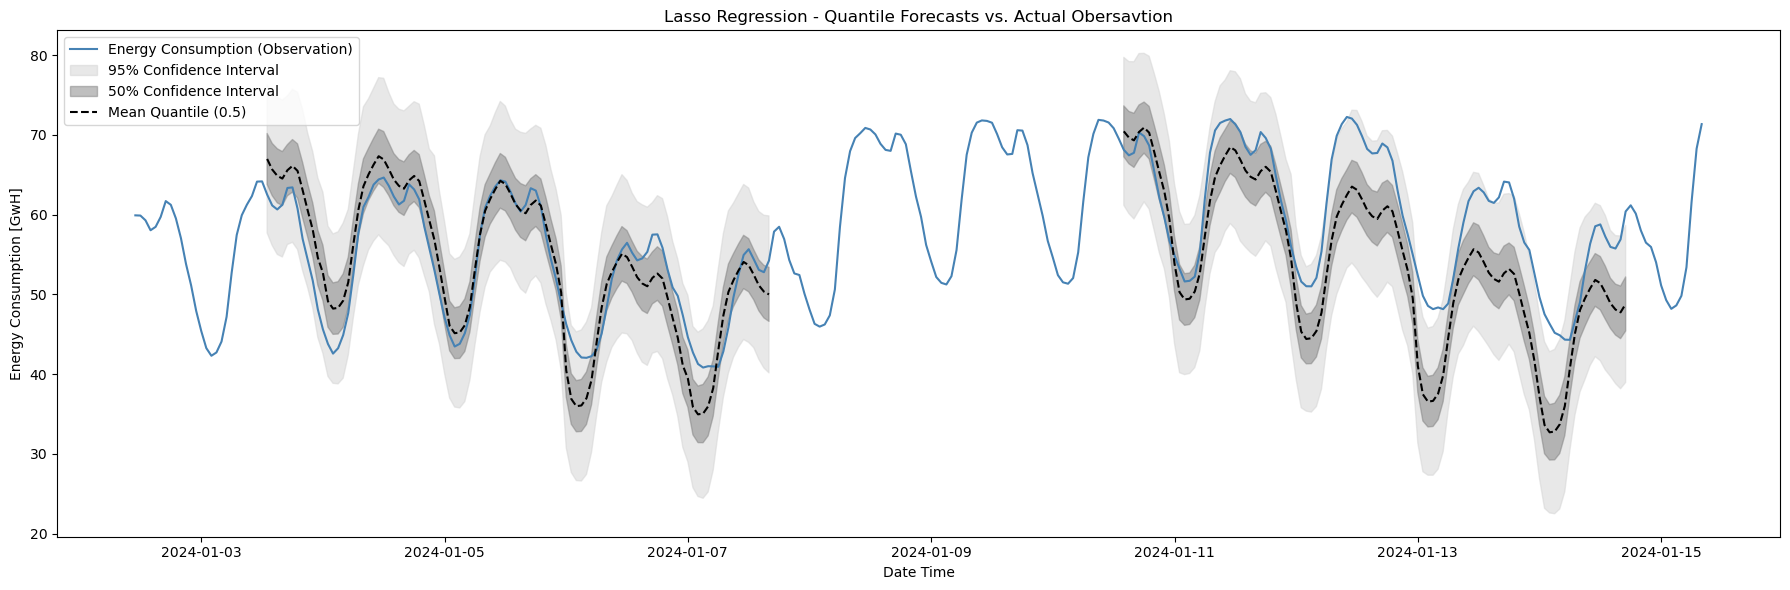

In [27]:
# Plotting
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 6))

# Plot energy consumption observations
ax.plot(df_combined['date_time'], df_combined['energy_consumption'],
        label='Energy Consumption (Observation)', color='steelblue')

# Fill between quantiles
ax.fill_between(df_combined['date_time'], df_combined['q0.025'], df_combined['q0.975'],
                color='lightgray', alpha=0.5, label='95% Confidence Interval')
ax.fill_between(df_combined['date_time'], df_combined['q0.25'], df_combined['q0.75'],
                color='gray', alpha=0.5, label='50% Confidence Interval')

# Plot mean quantile (0.5) as a line
ax.plot(df_combined['date_time'], df_combined['q0.5'],
        label='Mean Quantile (0.5)', linestyle='--', color='black')

# Customize the plot
ax.set(title='Lasso Regression - Quantile Forecasts vs. Actual Obersavtion',
       xlabel='Date Time',
       ylabel='Energy Consumption [GwH]')

ax.legend()
plt.tight_layout()
plt.show()

Further Absolute Evaluation 

In [208]:
# Data, on which lasso model was trained

from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata_hist = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata_hist['date_time'] = pd.to_datetime(
    energydata_hist['date_time'], format='%Y-%m-%d %H:%M:%S')

energydata_hist = energydata_hist.set_index("date_time")
energydata_hist = energydata_hist[-10000:]
energydata_hist = impute_outliers(energydata_hist)

In [ ]:
energydata_hist

In [ ]:
idx_max = energydata_hist.index.max()
energydata = energydata[idx_max:]
energydata

In [23]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# exactly 8 weekly rounds from energydata_hist to new data
for i in range(1, 40):
    print(f'start of round {i}')
    forecasts = get_Lasso_forecasts(energydata[:i*(-168)],
                                      indexes=list(range(0,100)),
                                      quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+100].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

start of round 1
did you update weather and index?
2017-12-11 00:00:00
2024-01-18 12:00:00
did you update weather and index?
2024-01-17 13:00:00
2024-01-22 16:00:00
                     constant  abs_log_ret_weekly  sun_hours      tavg  \
date_time                                                                
2024-01-17 13:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 14:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 15:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 16:00:00         1        3.330669e-16  -1.655125  0.020779   
2024-01-17 17:00:00         1        3.330669e-16  -1.655125  0.020779   
...                       ...                 ...        ...       ...   
2024-01-21 12:00:00         1        3.330669e-16   1.512349  1.779041   
2024-01-21 13:00:00         1        3.330669e-16   1.512349  1.779041   
2024-01-21 14:00:00         1        3.330669e-16   1.512349  1.779041   
2024-01-21 15:00:00  

In [24]:
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))
pit_merged

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption
0,2024-01-17 13:00:00,60.230386,62.312151,63.813250,65.095884,66.294731,67.493578,68.776212,70.277311,72.359076,inf,71.60325
1,2024-01-17 14:00:00,58.742001,60.879729,62.421182,63.738297,64.969372,66.200447,67.517562,69.059015,71.196743,inf,70.62675
2,2024-01-17 15:00:00,57.741042,59.953653,61.549102,62.912353,64.186552,65.460751,66.824003,68.419451,70.632062,inf,69.26850
3,2024-01-17 16:00:00,57.416226,59.622200,61.212862,62.572025,63.842401,65.112777,66.471940,68.062602,70.268576,inf,69.43150
4,2024-01-17 17:00:00,58.807968,60.897824,62.404757,63.692376,64.895882,66.099389,67.387008,68.893941,70.983797,inf,71.15625
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-04-30 12:00:00,43.499278,45.672098,47.238855,48.577591,49.828875,51.080158,52.418894,53.985651,56.158471,inf,45.82025
96,2023-04-30 13:00:00,42.655097,44.707609,46.187614,47.452224,48.634224,49.816225,51.080835,52.560840,54.613352,inf,43.43500
97,2023-04-30 14:00:00,41.245312,43.326076,44.826453,46.108470,47.306741,48.505011,49.787028,51.287406,53.368170,inf,41.38975
98,2023-04-30 15:00:00,40.244607,42.394150,43.944121,45.268514,46.506393,47.744271,49.068664,50.618636,52.768178,inf,40.30900


In [25]:
import matplotlib.pyplot as plt


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 991,
 0.2: 717,
 0.3: 464,
 0.4: 368,
 0.5: 280,
 0.6: 233,
 0.7: 199,
 0.8: 211,
 0.9: 221,
 1: 216}

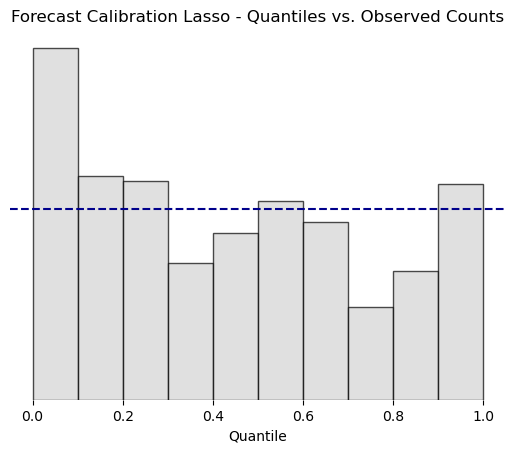

In [255]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

# Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration Lasso - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()